# **Fixed Effect Model & Investigation of local spill impacts**


## Purpose & Methodology

**For the fixed effects modeling**, the selected brine-related species include: Specific Conductivity (SC), Sodium (Na), Chloride (Cl), Barium (Ba), Sulfate (SO₄), Strontium (Sr), Bromide (Br), Iron (Fe), and Methane. These species either indicate salinity levels or are abundantly present in deep formation brine, making them effective tracers of potential impacts from UOGD activities.

In this model, we account for the potential confounding factors, including proximity to coal mining sites, conventional oil and gas (COG) wells and highways, topographic position (valley vs. ridge), and the season of sampling (winter vs. non-winter). These factors were selected based on their potential to contribute additional salt loading to Pennsylvania groundwater—such as through legacy coal mining, COG activities, and winter road salting. Topographic position may influence salt concentration due to differences in groundwater residence time and the potential for upward migration of deeper brine. Distance-based variables were converted to binary indicators, classifying samples based on whether they were located within 1 km of the relevant feature (e.g., coal mining, COG wells, or highways). Concentration data was log transformed to reduce skewness and distance metrics were in unit of km.

The final equation for the fixed effect model is:

$$ \log C = \beta_1 UOG/I/S + \gamma_1 CoalMining1km + \gamma_2 COG1km + \gamma_3 Highway1km + \gamma_4 TPI + \gamma_5 Season + \epsilon  $$

logC is the log concentration of brine-related species, UOG/I/S represents the geodesic distance metrics for all water samples, $β_1$ is the regression coefficient of the distance variables, and ε is the error term



**To investigate local spill impacts,** each spill sample was compared to the closest Shale Network sample and the basic statistics of Shale Network samples within 1km. Time series data was also plotted to show the groundwater chemistry difference before and after the spill incidents. 



# Setup

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
import statsmodels.api as sm
import statsmodels.formula.api as smf



# Data import


In [3]:
from pathlib import Path

# Set up paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "Dataset"
OUTPUT_DIR = PROJECT_ROOT / "Results"


In [4]:
# Import the dataset: df_fixed_effect.csv

### The dataset is a subset of the df_final and already excludes stream samples and samples impacted by AMD and rains, and it includes the following columns:

### 'Site ID': the unique identifier for each site
### 'Source': the source of the water samples
### 'Sample group': the subgroup where samples belong, hotspot(HS), impoundment(I), spill(S), control(C), or others(E)
### 'Date': the date of sampling
### 'DO' to '228Ra/226Ra': the water chemistry data of each sample, concentrations measured in mg/L
### '... DIST': the distance from the site to the nearest road/UOG well in hotspot areas/impoundment/spill/COG well/coal mine, measured in meters;
#  some are empty, meaning that they are more than 1km away from the features
### 'TPI300': the topographic position index, a measure of the site's elevation relative to its surroundings, based on Weiss et al. (2001)


##### This dataset contains the EPA standards for water quality & health risk data
df_epa= pd.read_csv(DATA_DIR/'EPA_Standard_with_health_risk.csv', header = 0)

### Bring in the dataset
df = pd.read_csv(DATA_DIR/'df_fixed_effect.csv', header = 0)
df_final = pd.read_csv(DATA_DIR/'2024_swpa_dataset.csv', header = 0)
df.head()

,Site ID,Source,Sample Group,Date,DO,SC,Field pH,Lab pH,Alkalinity,Gas Rover Reading,...,δ13C1(‰),δDC1(‰),δ13C2(‰),Near_Road_DIST,NEAR_UOG_DIST,Impoundment_DIST,Recent_Spill_DIST,NEAR_MINE_DIST,NEAR_COG_DIST,TPI300
0,Sample_001,well,Extra,2024-05-06,8.31,1011.0,8.99,8.73,NaN,18.0,...,NaN,NaN,NaN,689.633985,2176.241879,11113.031630,4564.651258,0.00000,NaN,4
1,Sample_002,well,I,2024-05-06,2.06,608.0,7.05,7.35,NaN,5.0,...,NaN,NaN,NaN,828.262346,6613.129281,232.812101,11379.670050,0.00000,NaN,2
2,Sample_003,spring,HS/S,2024-05-06,6.88,501.0,7.09,7.22,NaN,10.0,...,NaN,NaN,NaN,1680.192842,497.988440,10700.946770,406.571171,0.00000,645.041902,4
3,Sample_004,well,Extra,2024-05-07,9.07,530.0,7.41,7.61,NaN,5.0,...,NaN,NaN,NaN,231.116563,2991.209164,5783.635955,5476.030625,2.65047,NaN,5
4,Sample_005,well,HS/I,2024-05-08,1.14,957.0,7.03,7.41,NaN,5.0,...,NaN,NaN,NaN,1370.442128,776.993458,937.351060,7869.230059,NaN,NaN,4


In [69]:
df['Sample Group'].value_counts()

Sample Group
Extra    27
HS       17
I        14
S        11
HS/I     10
C         8
HS/S      3
Name: count, dtype: int64

# Spill samples that exceeded health thresholds

The following snippet is used to examine if the samples from the specific spills that we further investigate violate the health standards.

In [63]:
df_epa = df_epa.drop(range(0, 6))
df_epa = df_epa.reset_index(drop=True)

In [64]:
df_epa.loc[df_epa['list']=='Al','MCL/SMCL limit'] = 0.2

In [65]:
### Pick samples that I want to examine
df_sample_examine = df.copy()
df_sample_examine['Site ID Code'] = df_sample_examine['Site ID'].str.split('_').str[-1]
df_sample_examine = df_sample_examine[df_sample_examine['Site ID Code'].isin(['003', '013-3', '042', '090', '038', '081', '084','083'])]
df_sample_examine = df_sample_examine.drop(columns=['Site ID Code'])

In [66]:
### Loop the samples and check if they violate the EPA standards, if there is a violation, add a asterisk to the sample
for col in df_sample_examine.columns:
    if df_epa.loc[df_epa['list']== col, 'MCL/SMCL limit'].astype(str).ne('-').any():
        epa_standard = df_epa.loc[df_epa['list'] == col, 'MCL/SMCL limit'].astype(float).iloc[0]
        df_sample_examine[col] = df_sample_examine[col].astype(float)
        df_sample_examine[col] = df_sample_examine[col].apply(lambda x: f"{x}*" if x >= epa_standard else x)
# Display the samples that violate the EPA standards
df_sample_examine = df_sample_examine.reset_index(drop=True)
df_sample_examine


,Site ID,Source,Sample Group,Date,DO,SC,Field pH,Lab pH,Alkalinity,Gas Rover Reading,...,δ13C1(‰),δDC1(‰),δ13C2(‰),Near_Road_DIST,NEAR_UOG_DIST,Impoundment_DIST,Recent_Spill_DIST,NEAR_MINE_DIST,NEAR_COG_DIST,TPI300
0,Sample_003,spring,HS/S,2024-05-06,6.880,501.0,7.09,7.22,NaN,10.0,...,NaN,NaN,NaN,1680.192842,497.988440,10700.946770,406.571171,0.00000,645.041902,4
1,Sample_013-3,well,HS/S,2023-05-28,5.050,495.3,6.85,7.47,233.0,16.0,...,NaN,NaN,NaN,1876.164304,1544.007593,9494.400929,1728.722508,0.00000,NaN,4
2,Sample_038,well,S,2024-06-27,7.260,589.0,7.03,7.20,263.0,5.0,...,NaN,NaN,NaN,3786.271484,2784.791798,7379.900907,1967.658394,766.34314,NaN,5
3,Sample_042,well,HS/S,2024-07-15,2.930,671.0,7.19,7.60,385.0,5.0,...,NaN,NaN,NaN,2434.991613,1569.795792,10071.925520,1916.003352,0.00000,NaN,4
4,Sample_081,well,S,2024-09-16,4.240,728.0,6.76,6.89,305.0,11.0,...,NaN,NaN,NaN,1352.842618,8385.757069,8160.428689,1954.969634,0.00000,NaN,2
5,Sample_083,well,S,2024-09-16,6.750,621.0,7.23,7.62,183.0,5.0,...,NaN,NaN,NaN,888.618989,10952.761090,10971.314680,2824.575755,NaN,NaN,5
6,Sample_084,well,S,2024-09-16,0.416,686.0,7.08,7.32,272.0,5.0,...,NaN,NaN,NaN,566.951363,5910.536847,11478.093850,2820.231791,0.00000,NaN,4
7,Sample_090,well,S,2024-09-17,0.455,551.0,6.05,6.42,88.0,5.0,...,NaN,NaN,NaN,1228.090063,4414.795710,4491.557226,2592.088597,NaN,NaN,2


# Data Transformation & Define Function 

In [67]:
# -------------------------------get copy of the original data-------------------------------
df_original = df.copy()

# Select the analytes to be transformed
analyte = ['SC','Na','Cl','Ba','SO4','Sr','Br', 'Fe','Methane']
df_analyte = df[analyte]

# Check skewness of the analytes
print("Skewness of the original data: \n",df_analyte.skew(), "\n")

# ----------------------------------- Data transformation -----------------------------------

# --------------------- log transformation ---------------------
# log-transform the analytes - log(x+1) transformation, and the reverse is exp(x)-1
# This transformation is used to stabilize variance and make the residual more normally distributed
df_analyte_log = np.log(df_analyte + 1)
print("Skewness of the transformed data: \n",df_analyte_log.skew())

# replace the original data with the transformed data
df[analyte] = df_analyte_log


Skewness of the original data: 
 SC         3.539917
Na         3.455058
Cl         3.699052
Ba         6.126435
SO4        3.208372
Sr         1.645418
Br         9.048787
Fe         7.045551
Methane    7.861029
dtype: float64 

Skewness of the transformed data: 
 SC         1.189935
Na         0.646404
Cl         0.446624
Ba         4.781383
SO4       -1.645746
Sr         1.085954
Br         7.781678
Fe         5.770331
Methane    3.913371
dtype: float64


In [68]:
### Define the fixed effect modeling and make dummy variables for the analytes

# Metric - distance to closest UOG/I/S site (change the unit from meter to kilometer)
df['NEAR_UOG_well_DIST'] = df['NEAR_UOG_DIST']/1000
df['NEAR_I_DIST'] = df['Impoundment_DIST']/1000
df['NEAR_S_DIST'] = df['Recent_Spill_DIST']/1000

# Dummy variable for highway within 1km
df['Road_1km'] = np.where(df['Near_Road_DIST'] <= 1000, 1, 0)

# Dummy variable for TPI (1 for valley, 0 for ridge) [Categorical]
df['TPI'] = np.where(df['TPI300'] <= 3, 1, 0)

# Dummy variable for season (1 for winter, including month 11, 12, 1 and 2, corresponding to the timeframe of road salt application) [Categorical]
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = np.where(df['Date'].dt.month.isin([11, 12, 1, 2]), 1, 0)

# Dummy variable for Coal mining
df['Mine_1km'] = np.where(df['NEAR_MINE_DIST'] <= 1000, 1, 0)

# Dummy variable for COG
df['COG_1km'] = np.where(df['NEAR_COG_DIST'] <= 1000, 1, 0)

In [70]:
# Dummy variable for group (HS/I/S) & Variable for HS / non-HS group  [Categorical for the first case, C/E was excluded as a base case to avoid multicolliniarity]
df['HS'] = np.where(df['Sample Group'].str.contains('HS'), 1, 0)
df['I'] = np.where(df['Sample Group'].str.contains('I'), 1, 0)
df['S'] = np.where((df['Sample Group']=='S') | (df['Sample Group']=='HS/S'), 1, 0)
df['C'] = np.where(df['Sample Group'].str.contains('C'), 1, 0)

In [71]:
### Define the function for fixed effect modeling

def fixed_effect(X_var, analytes,variables, dataset):
    """
    This function performs fixed effect modeling on the given dataset for the specified analytes and variables.
    It returns a DataFrame containing the coefficients, intercepts, F-statistics and its significance levels.
    
    Input Parameters:
    analytes (list): List of analyte names to be analyzed.
    variables (list): List of dummy variable names to be included in the model
    dataset (DataFrame): The dataset containing the data for analysis.
    
    Returns:
    DataFrame with the following columns: 
    - Analyte: Name of the analyte
    - Analyte_Coefficient: Coefficient of the UOG metric 
    - Variables: List of coefficient of the dummy variables included 
    - F-statistic: F-statistic value for the model
    - F-statistic p-value: p-value for the F-statistic

    Values that are significant at the 0.05 level are marked with an asterisk (*).
    """
    # Create a table with analyte, variables' correlations, p_value for X variable, F-statistics, F-statistic p_value
    significance_threshold = 0.05
    X_corr_flagged = []
    var_corr = np.zeros((len(analytes), len(variables)))
    var_p_value = np.zeros((len(analytes), len(variables)))
    var_corr_flagged = var_corr.astype(str)

    
    # Loop through each analyte
    for idx, analyte in enumerate(analytes):
        y_var_name = analyte
        X_var_name = X_var

        # Construct lsdv and determine if the p-value is lower than 0.05
        lsdv_expr = y_var_name + ' ~ ' + X_var_name
        for var in variables:
            lsdv_expr += ' + ' + var
        lsdv = smf.ols(formula=lsdv_expr, data=dataset).fit()

        var_corr[analytes.index(analyte),:] = lsdv.params[variables]
        var_p_value[analytes.index(analyte),:] = lsdv.pvalues[variables]

        # Append the formatted correlation to X_corr_flagged
        X_corr_flagged.append(str(lsdv.params[X_var_name].round(3)) + ("*" if lsdv.pvalues[X_var_name] <= significance_threshold else "") + " (p = " + str(lsdv.pvalues[X_var_name].round(3)) + ")")

    # Add a "*" sign to every significant var_corr value
        for i in range(len(variables)):
            if var_p_value[analytes.index(analyte),i] <= significance_threshold:
                var_corr_flagged[analytes.index(analyte),i] = str(var_corr[analytes.index(analyte),i].round(3)) + "*" + " (p = " + str(var_p_value[analytes.index(analyte),i].round(3)) + ")"
            else:
                var_corr_flagged[analytes.index(analyte),i] = str(var_corr[analytes.index(analyte),i].round(3)) + " (p = " + str(var_p_value[analytes.index(analyte),i].round(3)) + ")"


    # --------------------- Plot residuals vs. fitted ---------------------
    # # Calculate fitted values and residuals
    #     fitted = lsdv.fittedvalues
    #     residuals = lsdv.resid

    #     # Plot residuals vs. fitted
    #     ax[idx].scatter(fitted, residuals)
    #     ax[idx].axhline(0, color='red', linestyle='--')
    #     ax[idx].set_xlabel('Fitted values')
    #     ax[idx].set_ylabel('Residuals')
    #     ax[idx].set_title(f'Residuals vs. Fitted for {analyte}')

    # Adjust the layout
    # plt.tight_layout()
    # plt.show()

    # # Save the figure
    # fig.savefig(f'./residuals_vs_fitted_{analyte}.png')

    
    # Construct a df with analyte, variables, and F-statistics
    combine = np.hstack((np.array(analytes).reshape(-1,1),
                        np.array(X_corr_flagged).reshape(-1,1),
                        var_corr_flagged))

    column = ['Analyte'] + [X_var_name] + variables

    df = pd.DataFrame(combine, columns=column)

    return df




# **Fixed effect model**
Table 4

In [72]:
### Prepare the lists of dummy variables
variables = ['COG_1km','Mine_1km','Road_1km', 'TPI', 'Season']

In [73]:
### Conc. vs. UOG well distance 

X_var = 'NEAR_UOG_well_DIST'
df_fixed_effect_HS = fixed_effect(X_var, analyte, variables, df)
df_fixed_effect_HS

,Analyte,NEAR_UOG_well_DIST,COG_1km,Mine_1km,Road_1km,TPI,Season
0,SC,0.003 (p = 0.687),0.169 (p = 0.3),0.091 (p = 0.341),0.079 (p = 0.39),-0.15 (p = 0.154),-0.26 (p = 0.42)
1,Na,0.044 (p = 0.091),0.244 (p = 0.621),0.403 (p = 0.167),-0.096 (p = 0.733),-0.144 (p = 0.652),-1.293 (p = 0.189)
2,Cl,-0.001 (p = 0.974),0.546 (p = 0.323),0.293 (p = 0.366),0.166 (p = 0.596),-0.177 (p = 0.618),-0.534 (p = 0.625)
3,Ba,0.003 (p = 0.272),0.163* (p = 0.002),-0.003 (p = 0.908),0.0 (p = 0.99),0.048 (p = 0.143),-0.163 (p = 0.108)
4,SO4,-0.041* (p = 0.01),-0.174 (p = 0.559),0.23 (p = 0.191),-0.069 (p = 0.684),-0.297 (p = 0.124),1.085 (p = 0.069)
5,Sr,-0.006 (p = 0.234),0.114 (p = 0.232),0.012 (p = 0.829),-0.041 (p = 0.449),0.01 (p = 0.875),0.138 (p = 0.465)
6,Br,0.01* (p = 0.014),0.228* (p = 0.003),0.069 (p = 0.122),-0.033 (p = 0.445),0.025 (p = 0.6),-0.36* (p = 0.017)
7,Fe,0.003 (p = 0.309),0.058 (p = 0.292),-0.055 (p = 0.094),0.049 (p = 0.122),-0.025 (p = 0.478),-0.068 (p = 0.536)
8,Methane,0.048* (p = 0.0),0.124 (p = 0.612),-0.042 (p = 0.771),0.224 (p = 0.11),-0.183 (p = 0.256),-1.138* (p = 0.02)


In [74]:
### Conc. vs. Impoundment distance
X_var = 'NEAR_I_DIST'
df_fixed_effect_I = fixed_effect(X_var, analyte, variables, df)
df_fixed_effect_I

,Analyte,NEAR_I_DIST,COG_1km,Mine_1km,Road_1km,TPI,Season
0,SC,0.007 (p = 0.435),0.172 (p = 0.29),0.066 (p = 0.505),0.088 (p = 0.342),-0.15 (p = 0.143),-0.321 (p = 0.307)
1,Na,0.039 (p = 0.176),0.229 (p = 0.646),0.258 (p = 0.4),-0.054 (p = 0.85),-0.066 (p = 0.833),-1.046 (p = 0.279)
2,Cl,-0.023 (p = 0.465),0.525 (p = 0.341),0.367 (p = 0.279),0.136 (p = 0.667),-0.145 (p = 0.676),-0.117 (p = 0.912)
3,Ba,0.007* (p = 0.013),0.166* (p = 0.001),-0.028 (p = 0.364),0.009 (p = 0.744),0.047 (p = 0.137),-0.234* (p = 0.016)
4,SO4,-0.028 (p = 0.115),-0.152 (p = 0.62),0.34 (p = 0.073),-0.097 (p = 0.58),-0.382* (p = 0.05),0.699 (p = 0.24)
5,Sr,-0.009 (p = 0.116),0.113 (p = 0.233),0.042 (p = 0.467),-0.051 (p = 0.347),0.004 (p = 0.942),0.168 (p = 0.36)
6,Br,0.017* (p = 0.0),0.233* (p = 0.002),0.011 (p = 0.797),-0.013 (p = 0.755),0.03 (p = 0.497),-0.456* (p = 0.001)
7,Fe,0.002 (p = 0.577),0.057 (p = 0.31),-0.062 (p = 0.072),0.051 (p = 0.114),-0.019 (p = 0.59),-0.036 (p = 0.738)
8,Methane,0.037* (p = 0.013),0.096 (p = 0.706),-0.178 (p = 0.261),0.258 (p = 0.081),-0.079 (p = 0.629),-0.755 (p = 0.128)


In [75]:
### Conc. vs. Spill distance
X_var = 'NEAR_S_DIST'
df_fixed_effect_S = fixed_effect(X_var, analyte, variables, df)
df_fixed_effect_S

,Analyte,NEAR_S_DIST,COG_1km,Mine_1km,Road_1km,TPI,Season
0,SC,-0.01 (p = 0.487),0.15 (p = 0.36),0.059 (p = 0.572),0.095 (p = 0.317),-0.156 (p = 0.135),-0.2 (p = 0.443)
1,Na,-0.105* (p = 0.02),0.038 (p = 0.939),0.072 (p = 0.819),0.066 (p = 0.818),-0.18 (p = 0.564),-0.483 (p = 0.538)
2,Cl,-0.054 (p = 0.279),0.468 (p = 0.397),0.134 (p = 0.704),0.255 (p = 0.429),-0.27 (p = 0.443),-0.645 (p = 0.465)
3,Ba,-0.008 (p = 0.071),0.147* (p = 0.005),-0.03 (p = 0.364),0.013 (p = 0.652),0.044 (p = 0.178),-0.112 (p = 0.17)
4,SO4,0.088* (p = 0.001),0.003 (p = 0.992),0.509* (p = 0.008),-0.203 (p = 0.239),-0.28 (p = 0.137),0.315 (p = 0.503)
5,Sr,-0.001 (p = 0.923),0.12 (p = 0.216),0.013 (p = 0.838),-0.038 (p = 0.497),-0.01 (p = 0.868),0.004 (p = 0.979)
6,Br,-0.002 (p = 0.832),0.214* (p = 0.007),0.059 (p = 0.24),-0.032 (p = 0.48),0.053 (p = 0.287),-0.144 (p = 0.253)
7,Fe,-0.012* (p = 0.021),0.038 (p = 0.485),-0.09* (p = 0.011),0.067* (p = 0.036),-0.035 (p = 0.309),-0.021 (p = 0.807)
8,Methane,-0.068* (p = 0.004),-0.038 (p = 0.882),-0.263 (p = 0.11),0.321* (p = 0.033),-0.138 (p = 0.403),-0.167 (p = 0.68)


In [76]:
### Summary of the results; Combine the coefficients of the three models
df_fixed_effect = pd.merge(df_fixed_effect_HS[['Analyte', 'NEAR_UOG_well_DIST']], df_fixed_effect_I[['Analyte', 'NEAR_I_DIST']], on='Analyte')
df_fixed_effect = pd.merge(df_fixed_effect, df_fixed_effect_S[['Analyte', 'NEAR_S_DIST']], on='Analyte')
df_fixed_effect = df_fixed_effect.rename({'NEAR_UOG_well_DIST':'UOG Well', 'NEAR_I_DIST':'Impoundment','NEAR_S_DIST':'Spill'})
df_fixed_effect.to_csv(OUTPUT_DIR/'Tables/Table 4 Fixed effect.csv',index=False)


#  **Analysis for specific spills** 



## **Define Function**

In [77]:
# Define the function to find nearby samples of a HEI sample within a specified distance
from geopy.distance import geodesic

def find_nearby_samples(df, target_coords, distance_km):
    """
    Find samples within a specified geodesic distance from a target coordinate.

    Parameters:
    df (DataFrame): The DataFrame containing sample coordinates.
    target_coords (list of tuple): The (latitude, longitude) of the target samples.
    distance_km (float): The distance in kilometers to search for nearby samples.

    Returns:
    DataFrame: A DataFrame containing samples within the specified distance;
    closest_sample: the sample closest to the target sample, or None if none found.
    """
    nearby_samples = []
    min_dist = float('inf')
    label = 1
    closest_sample = None
    for target_sample_coords in target_coords:
        for index, row in df.iterrows():
            # if the coordinates are using X and Y, convert them to latitude and longitude
            if 'Latitude' not in row and 'X' in row:
                sample_coords = (row['Y'], row['X'])
            else:
                # otherwise, use the latitude and longitude directly
                sample_coords = (row['Latitude'], row['Longitude'])
            distance = geodesic(target_sample_coords, sample_coords).km
            if distance <= distance_km:
                row['label'] = label
                nearby_samples.append(row)
                if distance < min_dist:
                    min_dist = distance
                    closest_sample = row
        label += 1
    closest_sample = closest_sample.to_frame().T.reset_index(drop=True)
    nearby_samples = pd.DataFrame(nearby_samples).reset_index(drop=True)
    return nearby_samples, closest_sample, min_dist


In [78]:
# Define a function for comparing the analytes in the nearby samples 
def compare_nearby_samples_with_sample(df_nearby, df_closest, min_dist, sample_ref):
    """
    Compare the analytes in the nearby samples with a reference sample.
    
    Parameters:
    df_nearby (DataFrame): DataFrame containing nearby samples.
    df_closest (DataFrame): DataFrame containing the closest sample to the reference sample.
    analyte (list): List of analytes to compare.
    min_dist (float): Minimum distance to the reference sample.
    sample_ref (Series): Series containing the reference sample analytes from HEI dataset.
    
    Returns:
    DataFrame: A DataFrame containing the comparison results.
    """
    # Adjust nearby samples to have the same analytes as the reference sample
    # Extract Site ID of the HEI sample and date of the closest sample for display
    Site_ID = sample_ref['Site ID'].values[0]
    Date_closest = df_closest['Date'].values[0]
    # Make the date present in the form of YYYY-MM-DD
    Date_closest = pd.to_datetime(Date_closest).strftime('%Y-%m-%d')
    sample_ref = sample_ref[analyte].T
    df_closest = df_closest[analyte].T
    df_nearby = df_nearby[analyte].T
    # Display the analyte concentration of nearby samples in ranges, caculate the min, max, and median of each row
    df_nearby_display = df_nearby.apply(lambda x: pd.Series({
        'min': x.min(),
        'median': x.median(),
        'max': x.max()
    }), axis=1)
    # Round up the min_dist
    min_dist = f"{round(min_dist*1000, 2)} m"
    # Create a comparison DataFrame
    comparison = pd.concat([sample_ref, df_closest, df_nearby_display], axis=1)
    comparison.columns = [f'{Site_ID}', f'Closest Sample ({min_dist})({Date_closest})', 'Nearby Samples Min', 'Nearby Samples Median', 'Nearby Samples Max']

    # Round the values in the comparison DataFrame
    comparison = comparison.round(3)

    return comparison

### <span style = "color: brown"> **Plot functions** </span>
1. **plot_bar_time_series(df_nearby, df_padep, analytes, sample_data, spill_Date)**
   
2. **plot_boxplot_time_series(df_nearby, df_padep, analytes, sample_data, spill_Date)**
   
3.  **plot_scatter_time_series(df_nearby, df_padep, analytes, sample_data, spill_Date)**

In [79]:
# Define a function to plot bar plots for time series data of the analytes, including the nearby samples and padep samples
def plot_bar_time_series(df_nearby, df_padep, analytes, sample_data, spill_Date):
    """
    Plot bar plots for time series data of the analytes, including the nearby samples and padep samples.
    
    Parameters:
    df_nearby (DataFrame): DataFrame containing nearby samples.
    df_closest (DataFrame): DataFrame containing the closest sample to the reference sample.
    df_padep (DataFrame): DataFrame containing padep samples.
    analytes (list): List of analytes to plot.
    sample (DataFrame): DataFrame containing the HEI sample data.
    spill_Date (str): The date of the spill event, used for marking on the plot.
    
    Returns:
    None
    """
    # Set the date as index
    # Plot the bars for each month in the date, with min,max and median values for the nearby samples and padep samples
    df_nearby_analyte = df_nearby.copy()
    df_padep_analyte = df_padep.copy()
    # Convert the 'Date' column to datetime format
    df_nearby_analyte['Date'] = pd.to_datetime(df_nearby_analyte['Date'], errors='coerce')
    df_padep_analyte['Date'] = pd.to_datetime(df_padep_analyte['Date'], errors='coerce')
    # Convert the date to month
    df_nearby_analyte['Date'] = df_nearby_analyte['Date'].dt.to_period('M')
    df_padep_analyte['Date'] = df_padep_analyte['Date'].dt.to_period('M')
    # Group by month and calculate min, max, and median for nearby samples
    df_nearby_analyte = df_nearby_analyte.groupby('Date').agg(['min', 'median', 'max']).reset_index()
    # Group by month and calculate min, max, and median for padep samples
    df_padep_analyte = df_padep_analyte.groupby('Date').agg(['min', 'median', 'max']).reset_index()

    # For sample data, we assume its date is "2024-06" and it would be plotted as a single point
    sample = sample_data.copy()
    sample['Date'] = pd.to_datetime('2024-06-01')  # Set a fixed date for the sample data
    sample['Date'] = sample['Date'].dt.to_period('M')  # Convert to month period
    sample_name = sample['Site ID'].values[0] 
    
    # Create a figure with subplots
    fig, axes = plt.subplots(len(analytes), 1, figsize=(10, 5 * len(analytes)), sharex=True)

    for i, analyte in enumerate(analytes):

        # Plot the nearby samples, bar plot for min and max values
        axes[i].bar(df_nearby_analyte['Date'].astype(str), height=df_nearby_analyte[analyte]['max']-df_nearby_analyte[analyte]['min'], bottom=df_nearby_analyte[analyte]['min'], label='Nearby Shale Network Samples', color='lightblue', alpha=0.7)
        # axes[i].hlines(df_nearby[analyte]['median'], df_nearby['Date'].astype(str), color='blue', label='Nearby Samples Median', linewidth=2)

        # Plot the padep samples, bar plot for min and max values
        axes[i].bar(df_padep_analyte['Date'].astype(str), height=df_padep_analyte[analyte]['max']-df_padep_analyte[analyte]['min'], bottom=df_padep_analyte[analyte]['min'], label='PADEP Samples', color='orange', alpha=0.7)
        # axes[i].hlines(df_padep[analyte]['median'], df_padep['Date'].astype(str), color='red', label='PADEP Samples Median', linewidth=2)

        # Plot the sample data as a single point
        axes[i].scatter(sample['Date'].astype(str), sample[analyte], color='green', label=sample_name, s=100, zorder=5)

        # Plot the spill date as a vertical line
        if spill_Date:
            axes[i].axvline(pd.to_datetime(spill_Date).strftime('%Y-%m'), color='red', linestyle='--', label='Spill Date')

        # Set the title and labels
        axes[i].set_title(f'{analyte} Concentration Over Time')
        axes[i].set_ylabel('Concentration')
        axes[i].legend()
        # axes[i].grid(True)
        # Set the x-axis label
        axes[i].set_xlabel('Date')
    # Adjust the layout
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Show the plot
    plt.show()
    # Save the plot
    # fig.savefig(f'./Brova pad - processing and results/Results_Brova/Figures/{sample_name}_time_series_plot.png')


In [80]:
# Define a function to plot box plots for the analytes in the nearby samples and padep samples
def plot_boxplot_time_series(df_nearby, df_padep, analytes, sample_data, spill_Date):
    """
    Plot box plots for the analytes in the nearby samples and padep samples for a time series comparison
    
    Parameters:
    df_nearby (DataFrame): DataFrame containing nearby samples.
    df_padep (DataFrame): DataFrame containing padep samples; can be None if not available
    analytes (list): List of analytes to plot.
    sample (DataFrame): DataFrame containing the HEI sample data.
    spill_Date (str): The date of the spill in the format 'YYYY-MM-DD' to be marked on the plots.
    
    Returns:
    None
    """
    df_nearby_analyte = df_nearby.copy()
    # Convert the 'Date' column to datetime format
    df_nearby_analyte['Date'] = pd.to_datetime(df_nearby_analyte['Date'], errors='coerce')
    # Convert the date to month
    df_nearby_analyte['Date'] = df_nearby_analyte['Date'].dt.to_period('M')

    # If padep data is provided, convert it to the same format
    if df_padep is not None:
        df_padep_analyte = df_padep.copy()
        df_padep_analyte['Date'] = pd.to_datetime(df_padep_analyte['Date'], errors='coerce')
        df_padep_analyte['Date'] = df_padep_analyte['Date'].dt.to_period('M')

    # For sample data, we assume its date is "2024-06" and it would be plotted as a single point
    sample = sample_data.copy()
    sample['Date'] = pd.to_datetime('2024-06-01')  # Set a fixed date for the sample data
    sample['Date'] = sample['Date'].dt.to_period('M')  # Convert to month period
    sample_name = sample['Site ID'].values[0] 
    
    # Create a figure with subplots
    fig, axes = plt.subplots(len(analytes), 1, figsize=(10, 5 * len(analytes)), sharex=True)

    # Loop through each analyte and create a box plot
    for i, analyte in enumerate(analytes):
        # Prepare the data for box plot
        nearby_data = df_nearby_analyte[[analyte, 'Date']].dropna()
        nearby_data['Source'] = 'Nearby Shale Network Samples'
        
        # If padep data is provided, prepare it for box plot
        if df_padep is not None:
            padep_data = df_padep_analyte[[analyte, 'Date']].dropna()
            padep_data['Source'] = 'PADEP Samples'
            combined_data = pd.concat([nearby_data, padep_data], ignore_index=True)
        else:
            combined_data = nearby_data

        # Add sample data as a separate point
        # sample_point = pd.DataFrame({analyte: sample[analyte].values[0], 'Date': sample['Date'].values[0], 'Source': sample_name}, index=[0])
        # combined_data = pd.concat([combined_data, sample_point], ignore_index=True)

        # Create the box plot
        sns.boxplot(x='Date', y=analyte, hue='Source', data=combined_data, ax=axes[i])

        # Scatter plot for the sample data
        axes[i].scatter(sample['Date'].astype(str), sample[analyte], color='green', label=sample_name, s=20, zorder=5)
        
        # Add a vertical line for the spill date
        spill_date = pd.to_datetime(spill_Date).to_period('M')
        axes[i].axvline(x=spill_date, color='red', linestyle='--', label='Spill Date')

        # Set the title and labels
        axes[i].set_title(f'{analyte} Concentration Over Time')
        axes[i].set_ylabel('Concentration')
        axes[i].legend(title='Source')
        # Set the x-axis label
        axes[i].set_xlabel('Date')
    # Adjust the layout
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Show the plot
    plt.show()




In [89]:
# Define a function to plot scatter plots for the analytes in the nearby samples and padep samples
import matplotlib.dates as mdates
import math

def plot_scatter_time_series(df_nearby, df_padep, analytes, sample_data, spill_Date, show_moving_average=False):
    """
    Plot scatter plots for the analytes in the nearby samples and padep samples for a time series comparison
    
    Parameters:
    df_nearby (DataFrame): DataFrame containing nearby samples.
    df_padep (DataFrame): DataFrame containing padep samples; can be None if not available
    analytes (list): List of analytes to plot.
    sample (DataFrame): DataFrame containing the HEI sample data.
    spill_Date (str): The date of the spill in the format 'YYYY-MM-DD' to be marked on the plots.
    show_moving_average (bool): Whether to show the moving average line for nearby samples.
    
    Returns:
    None
    """
    df_nearby_analyte = df_nearby.copy()
    # Convert the 'Date' column to datetime format
    df_nearby_analyte['Date'] = pd.to_datetime(df_nearby_analyte['Date'], errors='coerce')
    # Convert the date to month
    df_nearby_analyte['Date'] = df_nearby_analyte['Date'].dt.to_period('M')
    

    # If padep data is provided, convert it to the same format
    if df_padep is not None:
        df_padep_analyte = df_padep.copy()
        df_padep_analyte['Date'] = pd.to_datetime(df_padep_analyte['Date'], errors='coerce')
        df_padep_analyte['Date'] = df_padep_analyte['Date'].dt.to_period('M')

    # For sample data, we assume its date is "2024-06" and it would be plotted as a single point
    sample = sample_data.copy()
    sample['Date'] = pd.to_datetime('2024-06-01')  # Set a fixed date for the sample data
    sample['Date'] = sample['Date'].dt.to_period('M')  # Convert to month period
    sample_name = sample['Site ID'].values[0] 
    
    # Create a figure with subplots in two columns
    n_cols = 2
    n_rows = math.ceil(len(analytes) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 3*n_rows), sharex=False, sharey=False)
    axes = axes.ravel()  # Flatten the axes array for easy indexing

    # Loop through each analyte and create a scatter plot
    for i, analyte in enumerate(analytes):
        # Prepare the data for scatter plot
        nearby_data = df_nearby_analyte[[analyte, 'Date']].dropna()
        nearby_data['Source'] = 'SN Samples'

        # If padep data is provided, prepare it for scatter plot
        if df_padep is not None:
            padep_data = df_padep_analyte[[analyte, 'Date']].dropna()
            padep_data['Source'] = 'PADEP Samples'
            combined_data = pd.concat([nearby_data, padep_data], axis=0, ignore_index=True)
        else:
            combined_data = nearby_data
        # Add sample data as a separate point
        sample_point = pd.DataFrame({analyte: sample[analyte].values[0],'Date': sample['Date'].values[0],
                                    'Source': sample_name}, index=[0])
        combined_data = pd.concat([combined_data, sample_point], axis=0, ignore_index=True)

        # Convert the index to matplotlib float format for plotting
        combined_data['Date'] = mdates.date2num(combined_data['Date'])

        # Create color patterns for different sources
        colors = {'SN Samples': '#5DADE2', 'PADEP Samples': '#FFA500', sample_name: 'green'}

        # Create the scatter plot (exclude sample point, plot it separately with higher zorder)
        for source, grp in combined_data.groupby('Source'):
            if source == sample_name:
                continue  # Skip sample point here, plot it separately below
            axes[i].scatter(
            grp['Date'],
            grp[analyte],
            label=source, 
            color = colors[source], 
            # alpha=0.7,
            s=10,
            zorder=5
            )
        
        # Plot sample point with higher zorder so it appears on top
        sample_grp = combined_data[combined_data['Source'] == sample_name]
        axes[i].scatter(sample_grp['Date'], sample_grp[analyte], label=sample_name, 
                        color='green', s=30, zorder=15)
        
        # Calculate and plot time-based moving average for nearby samples (optional)
        # Using time-based window (e.g., 90 days) instead of count-based to avoid bias from uneven sampling
        if show_moving_average:
            nearby_sorted = combined_data[combined_data['Source'] == 'SN Samples'].copy()
            nearby_sorted = nearby_sorted.sort_values('Date')
            # Convert matplotlib date numbers back to datetime for time-based rolling
            nearby_sorted['DateTime'] = pd.to_datetime(mdates.num2date(nearby_sorted['Date']))
            nearby_sorted = nearby_sorted.set_index('DateTime')
            if len(nearby_sorted) >= 2:
                nearby_sorted['MA'] = nearby_sorted[analyte].rolling('180D', min_periods=1).mean()
                axes[i].plot(nearby_sorted['Date'], nearby_sorted['MA'], color='black', linewidth=1.5, 
                        label='SN MA (180-day)', linestyle='-', zorder=10)
        
        # Calculate and plot time-based moving average for PADEP samples
        if df_padep is not None:
            padep_sorted = combined_data[combined_data['Source'] == 'PADEP Samples'].copy()
            padep_sorted = padep_sorted.sort_values('Date')
            # Convert matplotlib date numbers back to datetime for time-based rolling
            padep_sorted['DateTime'] = pd.to_datetime(mdates.num2date(padep_sorted['Date']))
            padep_sorted = padep_sorted.set_index('DateTime')
            if len(padep_sorted) >= 2:
                padep_sorted['MA'] = padep_sorted[analyte].rolling('180D', min_periods=1).mean()
                axes[i].plot(padep_sorted['Date'], padep_sorted['MA'], color='black', linewidth=1.5, 
                    label='PADEP Samples MA (180-day)', linestyle='--', zorder=10)
                
        # Add a vertical line for the spill date
        spill_date = pd.to_datetime(spill_Date).to_period('M')
        axes[i].axvline(x=mdates.date2num(spill_date), color='red', linestyle='--', label='Spill Date')
        # Set the title and labels
        # axes[i].set_title(f'{analyte} Concentration Over Time')
        # Add analyte label in top left corner
        axes[i].text(0.02, 0.98, f'[{analyte}]', transform=axes[i].transAxes, 
                    fontsize=12, fontweight='bold', va='top', ha='left')
        if analyte == 'SC':
            axes[i].set_ylabel('Specific Conductance (µS/cm)')
        else:
            axes[i].set_ylabel('Concentration (mg/L)')
        # axes[i].legend(title='Source')
        # Format the x-axis to show dates properly
        axes[i].xaxis.set_major_locator(mdates.YearLocator(2))  # Every 2 years     
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axes[i].tick_params(axis='x', labelbottom = True)
    
    # Delete the empty subplot if the number of analytes is odd
    if len(analytes) % n_cols != 0:
        fig.delaxes(axes[-1])

    # ❶ Collect handles + labels from the first axis (or concatenate across axes)
    handles, labels = axes.ravel()[0].get_legend_handles_labels()

    # ❷ Make a figure‑level legend
    fig.legend(handles, labels,
            title="Source",
            loc="lower center",
            ncol=len(labels),            # one row; or choose a smaller ncol
            frameon=False)
    
    # Adjust the layout
    plt.tight_layout()
    # ❸ Add space underneath so the legend isn’t clipped
    fig.subplots_adjust(bottom=0.12)
    plt.savefig(f'{OUTPUT_DIR}/Figures/{sample_name}_scatter_time_series.pdf', bbox_inches='tight')
    # Show the plot
    plt.show()


##   **Spill B - Sample_082**

In [82]:
### df_wa is a subset of Shale Network dataset containing only samples from Washington County
df_wa = pd.read_csv(DATA_DIR/'shale_network_washington.csv', header = 0)

In [ ]:
### Using WGS 1984 Datum, look for samples within 1km geodesic distance from sample 82 
# Define the target coordinates for sample 82
coords_82 = df_final[df_final['Site ID'] == 'Sample_082'][['Latitude', 'Longitude']].values[0]

sample_82_coordinate = [(coords_82[0], coords_82[1])]  # (latitude, longitude)
# Find samples within 1km of sample 82
nearby_samples_82, closest_sample_82, min_dist_82 = find_nearby_samples(df_wa, sample_82_coordinate, 1.0)
# Display the nearby samples
### Compare the closest sample with sample 82
SAMPL82 = df_original[df_original['Site ID'] == 'Sample_082']

### Compare the closest sample with sample 82
comparison_for_82 = compare_nearby_samples_with_sample(nearby_samples_82, closest_sample_82, min_dist_82, SAMPL82)
comparison_for_82.to_csv(OUTPUT_DIR/'Tables/Table S14 Comparison result for Sample_082.csv', index=True)
comparison_for_82

C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,Sample_082,Closest Sample (6.74 m)(2011-05-11),Nearby Samples Min,Nearby Samples Median,Nearby Samples Max
SC,3485.000,2027.0,349.000,785.000,4369.000
Na,622.000,423.43,8.227,31.434,423.430
Cl,697.000,318.9,5.000,11.000,318.900
Ba,2.050,1.251,0.020,0.074,1.251
SO4,9.680,19.0,19.000,96.000,575.000
Sr,2.100,1.257,0.201,0.877,2.103
Br,5.813,NaN,NaN,NaN,NaN
Fe,0.005,0.99,0.010,0.049,0.990
Methane,0.140,2.5,2.500,2.500,2.500


In [85]:
# Number of nearby samples
print(f"Number of nearby samples for sample 82: {len(nearby_samples_82)}")

Number of nearby samples for sample 82: 17


In [86]:
# Save the comparison result
comparison_for_82_save = comparison_for_82.copy()
comparison_for_82_save.to_csv(OUTPUT_DIR/'Tables/Table S14.csv', index=True)

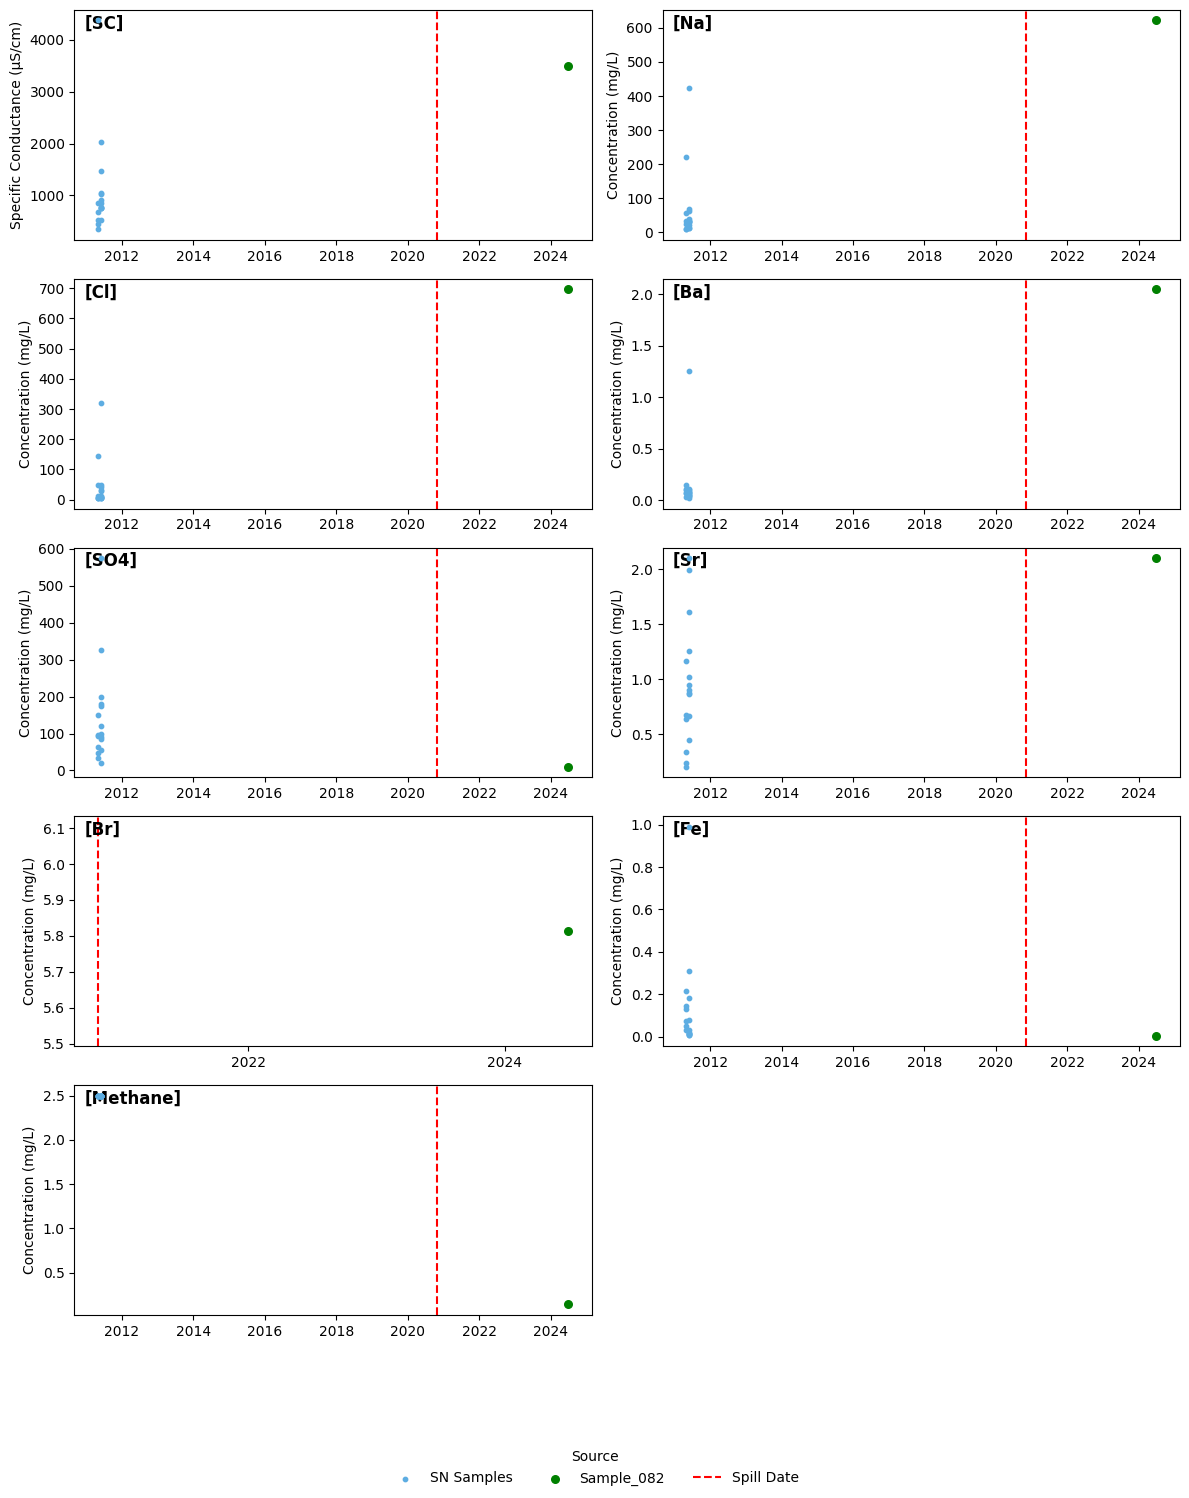

In [90]:
plot_scatter_time_series(nearby_samples_82, None, analyte, SAMPL82, '2020-10-29')

### **Fixed effect modeling without sample 82**

In [91]:
### Get a dataset without sample 82 for further analysis
df_without_82 = df[df['Site ID'] != 'Sample_082']

### Fixed effect for S
X_var = 'NEAR_S_DIST'
fixed_effect_S_without_82 = fixed_effect(X_var, analyte, variables, df_without_82)
fixed_effect_S_without_82.rename(columns={'NEAR_S_DIST': 'Spill without 82'}, inplace=True)

# save the results to a CSV file
fixed_effect_S_without_82.to_csv(OUTPUT_DIR/'Tables/Table S17.csv', index=False)

# Display the results
fixed_effect_S_without_82

,Analyte,Spill without 82,COG_1km,Mine_1km,Road_1km,TPI,Season
0,SC,-0.01 (p = 0.474),-0.074 (p = 0.638),0.011 (p = 0.909),0.129 (p = 0.138),-0.212* (p = 0.028),-0.082 (p = 0.732)
1,Na,-0.104* (p = 0.018),-0.379 (p = 0.451),-0.018 (p = 0.953),0.129 (p = 0.643),-0.285 (p = 0.351),-0.261 (p = 0.732)
2,Cl,-0.053 (p = 0.278),0.033 (p = 0.954),0.04 (p = 0.907),0.321 (p = 0.309),-0.379 (p = 0.274),-0.413 (p = 0.633)
3,Ba,-0.008* (p = 0.015),0.033 (p = 0.38),-0.054* (p = 0.021),0.031 (p = 0.146),0.015 (p = 0.513),-0.051 (p = 0.375)
4,SO4,0.087* (p = 0.001),0.122 (p = 0.694),0.534* (p = 0.006),-0.221 (p = 0.201),-0.25 (p = 0.187),0.251 (p = 0.594)
5,Sr,-0.001 (p = 0.943),0.039 (p = 0.693),-0.005 (p = 0.936),-0.026 (p = 0.635),-0.031 (p = 0.611),0.047 (p = 0.755)
6,Br,-0.001 (p = 0.778),-0.011 (p = 0.75),0.011 (p = 0.613),0.002 (p = 0.925),-0.003 (p = 0.873),-0.024 (p = 0.644)
7,Fe,-0.012* (p = 0.021),0.041 (p = 0.479),-0.09* (p = 0.012),0.067* (p = 0.039),-0.034 (p = 0.327),-0.023 (p = 0.795)
8,Methane,-0.068* (p = 0.004),-0.041 (p = 0.879),-0.264 (p = 0.114),0.322* (p = 0.034),-0.139 (p = 0.407),-0.165 (p = 0.687)


## **Spill A - Sample 003, 013-3, 042**

In [ ]:
df_spill_a = df_original[df_original['Site ID'].isin(['Sample_003', 'Sample_013-3', 'Sample_042'])]

### Sample_003

In [ ]:
# Sample HEI_003 Coords
coords_003 = df_final[df_final['Site ID'] == 'Sample_003'][['Latitude', 'Longitude']].values[0]
sample_003_coords = [(coords_003[0], coords_003[1])]  # (latitude, longitude)

In [97]:
# import PADEP data for plotting
padep_data_for_plot = pd.read_csv(DATA_DIR/'PADEP_data.csv', header = 0)

In [110]:
padep_data_for_plot.columns

Index(['SC', 'Br', 'Cl', 'Ba', 'Fe', 'Sr', 'Date'], dtype='object')

In [98]:
padep_data_copy = padep_data_for_plot.copy()

# drop rows in padep_data_copy if there is only value in Date (all other columns are NaN)
non_date_cols = [col for col in padep_data_copy.columns if col != 'Date']
padep_data_copy = padep_data_copy.dropna(subset=non_date_cols, how='all')
padep_data_copy.shape

(292, 7)

In [99]:
padep_data_test = padep_data_copy.copy()
padep_data_test = padep_data_test.drop(columns=['Date'])
print(padep_data_test.min(), '\n', padep_data_test.max(), '\n', padep_data_test.median())


SC    168.00000
Br      0.07200
Cl      2.46000
Ba      0.00989
Fe      0.18500
Sr      0.05140
dtype: float64 
 SC    25500.0
Br      102.0
Cl      920.0
Ba       13.9
Fe       18.5
Sr       76.4
dtype: float64 
 SC    1145.000
Br       0.362
Cl      32.700
Ba       0.250
Fe       0.185
Sr       1.050
dtype: float64


In [ ]:
### Locate nearby samples from df_wa
nearby_samples_003, closest_sample_003, min_dist_003 = find_nearby_samples(df_wa, sample_003_coords, 1.3)
# Display the nearby samples
nearby_samples_003

,SN sample,Latitude,Longitude,Alkalinity,As,Ba,Benzene,Br,Cd,Ca,...,K,Propane,Na,SC,Sr,SO4,Toluene,Xylene(total),Date,label
0,89,40.11453,-80.10122,178.0,0.01,0.086,NaN,NaN,NaN,60.428,...,1.118,NaN,19.139,487.0,0.303,34.0,NaN,NaN,2012-03-09,1
1,90,40.10892,-80.09056,224.0,0.01,0.048,NaN,NaN,NaN,76.213,...,1.540,NaN,8.553,556.0,0.765,50.0,NaN,NaN,2012-03-09,1
2,1225,40.11856,-80.10155,334.0,0.01,0.059,1.0,NaN,NaN,97.000,...,1.640,NaN,28.700,722.0,0.858,61.8,1.0,1.0,2013-08-09,1
3,1226,40.11562,-80.09884,326.0,0.01,0.100,1.0,NaN,NaN,116.000,...,1.230,NaN,8.180,682.6,0.545,57.6,1.0,1.0,2013-08-06,1
4,1227,40.11968,-80.09573,274.0,0.01,0.132,1.0,NaN,NaN,80.500,...,2.080,NaN,31.200,615.6,0.670,38.5,1.0,1.0,2013-08-06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,3170,40.12254,-80.09588,49.0,NaN,NaN,1.0,0.2,NaN,55.100,...,1.400,0.0032,10.300,414.0,NaN,34.1,1.0,3.0,2016-06-27,1
76,3171,40.12718,-80.09699,248.0,NaN,NaN,1.0,0.2,NaN,96.400,...,0.980,0.0032,5.100,554.0,NaN,36.9,1.0,3.0,2013-11-12,1
77,3172,40.12304,-80.09863,30.0,NaN,NaN,1.0,0.2,NaN,33.700,...,1.700,0.0032,45.600,478.0,NaN,24.0,1.0,3.0,2016-06-30,1
78,3888,40.10895,-80.09055,330.0,0.01,0.063,NaN,NaN,NaN,111.000,...,2.140,NaN,13.900,697.0,1.330,51.6,NaN,NaN,2012-10-02,1


In [109]:
Sampl003 = df_original[df_original['Site ID'] == 'Sample_003']
# Compare the closest sample with sample 003
Sampl003_comparison = compare_nearby_samples_with_sample(nearby_samples_003, closest_sample_003, min_dist_003, Sampl003)

# Include the PADEP data (min, median, max) in the comparison table
padep_data_003_display = pd.concat([padep_data_test.min(), padep_data_test.median(), padep_data_test.max()], axis=1)
padep_data_003_display.columns = ['Nearby PADEP Samples (Min)', 'Nearby PADEP Samples (Median)', 'Nearby PADEP Samples (Max)']


# Combine the comparison table with the PADEP data by matching the analyte names in the index
Sampl003_comparison = Sampl003_comparison.join(padep_data_003_display)

Sampl003_comparison.to_csv(OUTPUT_DIR/'Tables/Table S11 Comparison result for Sample_003.csv', index=True)
Sampl003_comparison
# padep_data_003_display

,Sample_003,Closest Sample (8.56 m)(2013-11-15),Nearby Samples Min,Nearby Samples Median,Nearby Samples Max,Nearby PADEP Samples (Min),Nearby PADEP Samples (Median),Nearby PADEP Samples (Max)
SC,501.000,462.0,93.500,542.000,1360.000,168.00000,1145.000,25500.0
Na,6.390,6.22,1.400,14.300,287.000,NaN,NaN,NaN
Cl,12.500,17.8,2.500,7.000,112.000,2.46000,32.700,920.0
Ba,0.160,0.123,0.025,0.088,0.182,0.00989,0.250,13.9
SO4,25.300,32.0,2.000,40.650,380.000,NaN,NaN,NaN
Sr,0.400,0.433,0.037,0.454,1.520,0.05140,1.050,76.4
Br,0.023,NaN,0.200,0.200,0.280,0.07200,0.362,102.0
Fe,0.005,0.025,0.010,0.130,14.400,0.18500,0.185,18.5
Methane,0.001,2.5,0.002,2.500,6.910,NaN,NaN,NaN


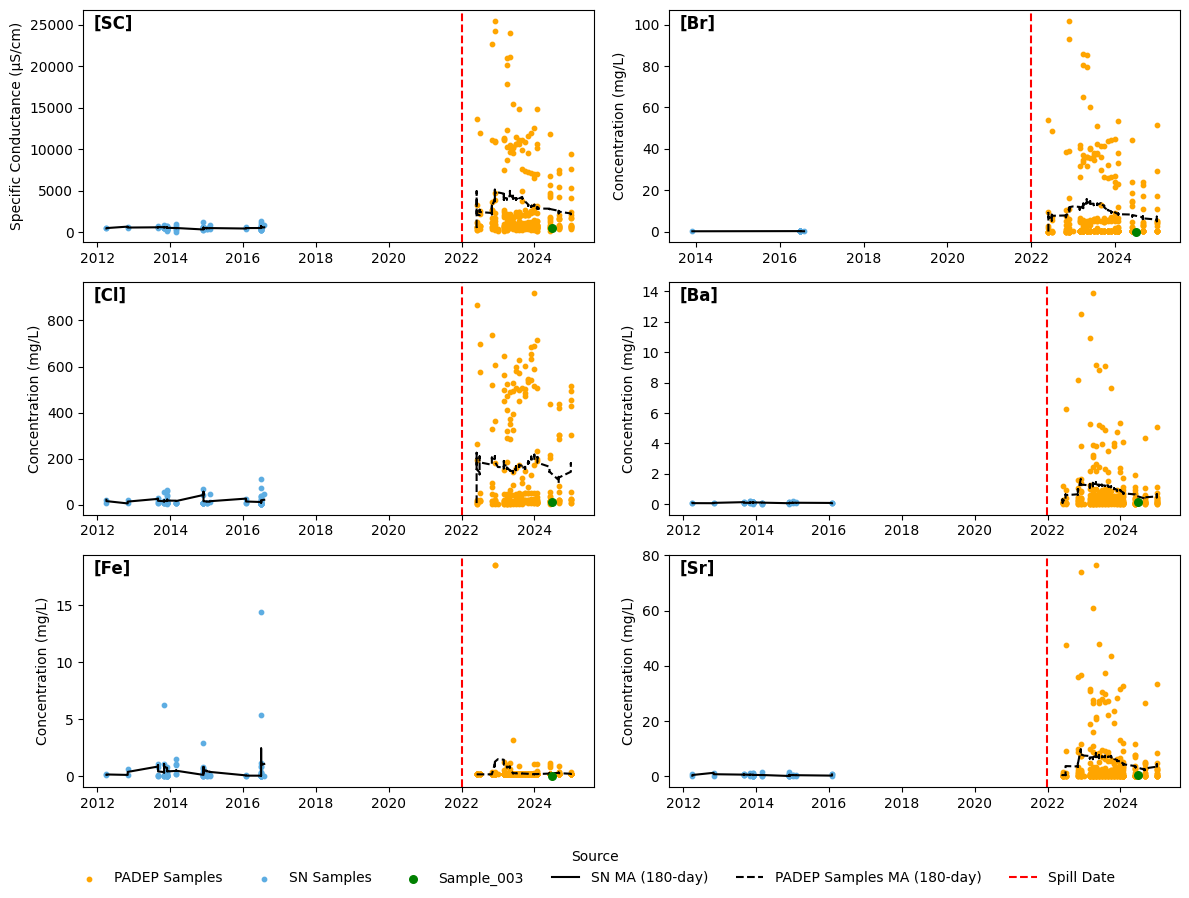

In [112]:
plot_scatter_time_series(nearby_samples_003, padep_data_for_plot, ['SC', 'Br', 'Cl', 'Ba', 'Fe', 'Sr'], Sampl003, '2021-12-04', True)

### Sample_013-3

In [ ]:
# sample name:  HEI_013-3
coords_013 = df_final[df_final['Site ID'] == 'Sample_013-3'][['Latitude', 'Longitude']].values[0]
sample_013_3_coords = [(coords_013[0], coords_013[1])]  # Coordinates of sample 013_3
Sample_013_3 = df_original[df_original['Site ID'] == 'Sample_013-3']
# Find samples within 1km of sample 013_3
nearby_samples_013_3, closest_sample_013_3, min_dist_013_3 = find_nearby_samples(df_wa, sample_013_3_coords, 1)
# Display the nearby samples
nearby_samples_013_3

,SN sample,Latitude,Longitude,Alkalinity,As,Ba,Benzene,Br,Cd,Ca,...,K,Propane,Na,SC,Sr,SO4,Toluene,Xylene(total),Date,label
0,1299,40.13972,-80.11360,82.1,0.01,0.037,1.0,NaN,NaN,33.50,...,1.960,8.4000,6.99,186.4,0.104,21.2,1.0,1.0,2014-03-14,1
1,1300,40.14035,-80.11351,272.0,0.01,0.019,1.0,NaN,NaN,4.71,...,2.100,8.4000,129.00,421.0,0.034,14.4,1.0,1.0,2014-03-14,1
2,1301,40.14040,-80.11349,20.0,0.01,0.026,1.0,NaN,NaN,7.02,...,0.609,8.4000,1.59,40.9,0.026,5.0,1.0,1.0,2014-03-14,1
3,2516,40.13226,-80.09572,341.0,0.01,0.183,1.0,NaN,NaN,43.80,...,1.590,NaN,80.30,624.0,0.750,23.0,1.0,1.0,2013-11-14,1
4,2523,40.13251,-80.09837,270.0,0.01,0.104,1.0,NaN,NaN,62.70,...,1.380,NaN,50.30,549.0,0.560,41.4,1.0,1.0,2013-11-15,1
5,2524,40.12601,-80.10062,31.0,0.01,0.072,1.0,NaN,NaN,15.90,...,1.450,NaN,4.82,137.6,0.087,28.2,1.0,1.0,2013-11-14,1
6,2525,40.13331,-80.09779,264.0,0.01,0.099,1.0,NaN,NaN,79.90,...,1.400,NaN,7.63,533.0,0.583,35.2,1.0,1.0,2013-11-15,1
7,2528,40.12834,-80.10157,240.0,0.01,0.030,1.0,NaN,NaN,115.00,...,1.990,NaN,6.59,597.0,0.562,196.0,1.0,1.0,2013-11-14,1
8,2536,40.12962,-80.09732,226.0,0.01,0.134,1.0,NaN,NaN,75.50,...,1.300,NaN,6.66,463.0,0.453,58.0,1.0,1.0,2013-11-14,1
9,2541,40.13017,-80.09849,320.0,0.01,0.094,1.0,NaN,NaN,55.20,...,2.120,NaN,69.40,642.0,0.934,38.5,1.0,1.0,2013-11-12,1


In [115]:
# Compare the closest sample with sample 013-3
Sample_013_3_comparison = compare_nearby_samples_with_sample(nearby_samples_013_3, closest_sample_013_3, min_dist_013_3, Sample_013_3)
Sample_013_3_comparison.to_csv(OUTPUT_DIR/'Tables/Table S12 Comparison result for Sample_013-3.csv', index=True)
Sample_013_3_comparison

,Sample_013-3,Closest Sample (631.97 m)(2013-11-15),Nearby Samples Min,Nearby Samples Median,Nearby Samples Max
SC,495.300,549.0,40.900,542.950,905.000
Na,4.770,50.3,1.590,10.215,129.000
Cl,3.550,5.0,2.600,5.000,36.800
Ba,0.170,0.104,0.019,0.094,0.183
SO4,26.200,41.4,5.000,38.900,229.000
Sr,0.260,0.56,0.026,0.561,0.973
Br,0.024,NaN,0.200,0.200,0.200
Fe,0.005,0.188,0.020,0.144,3.600
Methane,0.014,2.5,0.002,2.500,2.500


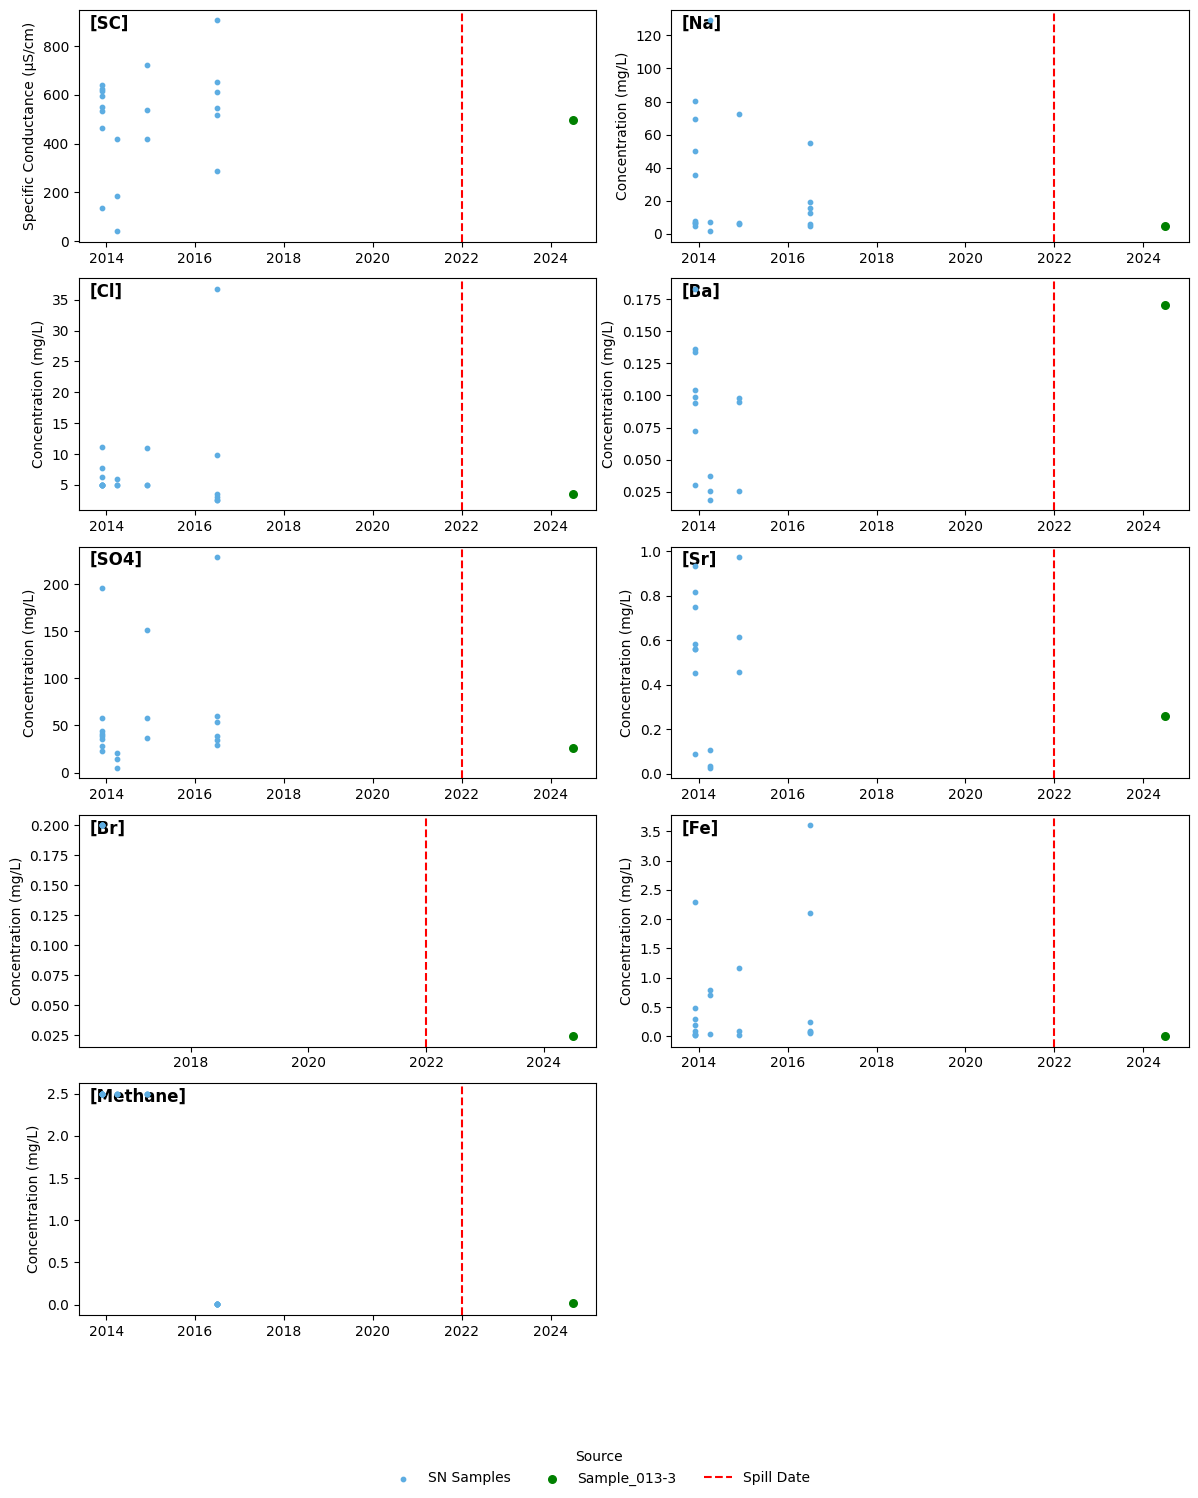

In [116]:
plot_scatter_time_series(nearby_samples_013_3, None, analyte, Sample_013_3, '2021-12-04')

### Sample_042

In [ ]:
# Sample_042
coords_042 = df_final[df_final['Site ID'] == 'Sample_042'][['Latitude', 'Longitude']].values[0]
sample_042_coords = [(coords_042[0], coords_042[1])]  # Coordinates of sample 042
# Find samples within 1km of sample 042
nearby_samples_042, closest_sample_042, min_dist_042 = find_nearby_samples(df_wa, sample_042_coords, 1)
# Display the nearby samples
nearby_samples_042

,SN sample,Latitude,Longitude,Alkalinity,As,Ba,Benzene,Br,Cd,Ca,...,K,Propane,Na,SC,Sr,SO4,Toluene,Xylene(total),Date,label
0,1272,40.14472,-80.10601,189.0,0.01,0.080,1.0,NaN,NaN,60.7,...,1.48,NaN,21.60,376.0,0.343,36.8,1.0,1.0,2014-04-01,1
1,1278,40.14436,-80.10545,250.0,0.01,0.086,1.0,NaN,NaN,67.9,...,1.87,8.4000,22.70,392.0,1.140,25.8,1.0,1.0,2014-03-14,1
2,1287,40.14290,-80.10812,76.4,0.01,0.094,1.0,NaN,NaN,30.0,...,1.44,8.4000,4.10,174.5,0.183,14.9,1.0,1.0,2014-03-13,1
3,2516,40.13226,-80.09572,341.0,0.01,0.183,1.0,NaN,NaN,43.8,...,1.59,NaN,80.30,624.0,0.750,23.0,1.0,1.0,2013-11-14,1
4,2518,40.13174,-80.09237,288.0,0.01,0.126,1.0,NaN,NaN,96.7,...,1.27,NaN,12.60,632.0,0.709,36.3,1.0,1.0,2013-11-12,1
5,2523,40.13251,-80.09837,270.0,0.01,0.104,1.0,NaN,NaN,62.7,...,1.38,NaN,50.30,549.0,0.560,41.4,1.0,1.0,2013-11-15,1
6,2525,40.13331,-80.09779,264.0,0.01,0.099,1.0,NaN,NaN,79.9,...,1.40,NaN,7.63,533.0,0.583,35.2,1.0,1.0,2013-11-15,1
7,2536,40.12962,-80.09732,226.0,0.01,0.134,1.0,NaN,NaN,75.5,...,1.30,NaN,6.66,463.0,0.453,58.0,1.0,1.0,2013-11-14,1
8,2541,40.13017,-80.09849,320.0,0.01,0.094,1.0,NaN,NaN,55.2,...,2.12,NaN,69.40,642.0,0.934,38.5,1.0,1.0,2013-11-12,1
9,2545,40.13149,-80.09840,286.0,0.01,0.136,1.0,NaN,NaN,74.4,...,1.36,NaN,35.70,617.0,0.816,44.4,1.0,1.0,2013-11-14,1


In [118]:
# compare the closest sample
Sample_042 = df_original[df_original['Site ID'] == 'Sample_042']
# Compare the closest sample with sample 042
Sample_042_comparison = compare_nearby_samples_with_sample(nearby_samples_042, closest_sample_042, min_dist_042, Sample_042)
Sample_042_comparison.to_csv(OUTPUT_DIR/'Tables/Table S13 Comparison result for Sample_042.csv', index=True)
Sample_042_comparison

,Sample_042,Closest Sample (500.17 m)(2013-11-15),Nearby Samples Min,Nearby Samples Median,Nearby Samples Max
SC,671.000,533.0,174.500,542.950,652.000
Na,76.300,7.63,4.100,15.150,80.300
Cl,16.200,7.65,2.600,5.000,22.900
Ba,0.160,0.099,0.080,0.099,0.183
SO4,32.900,35.2,14.900,36.600,60.000
Sr,0.460,0.583,0.183,0.709,1.140
Br,0.027,NaN,0.200,0.200,0.200
Fe,0.005,0.034,0.010,0.086,2.100
Methane,0.027,2.5,0.002,2.500,2.500


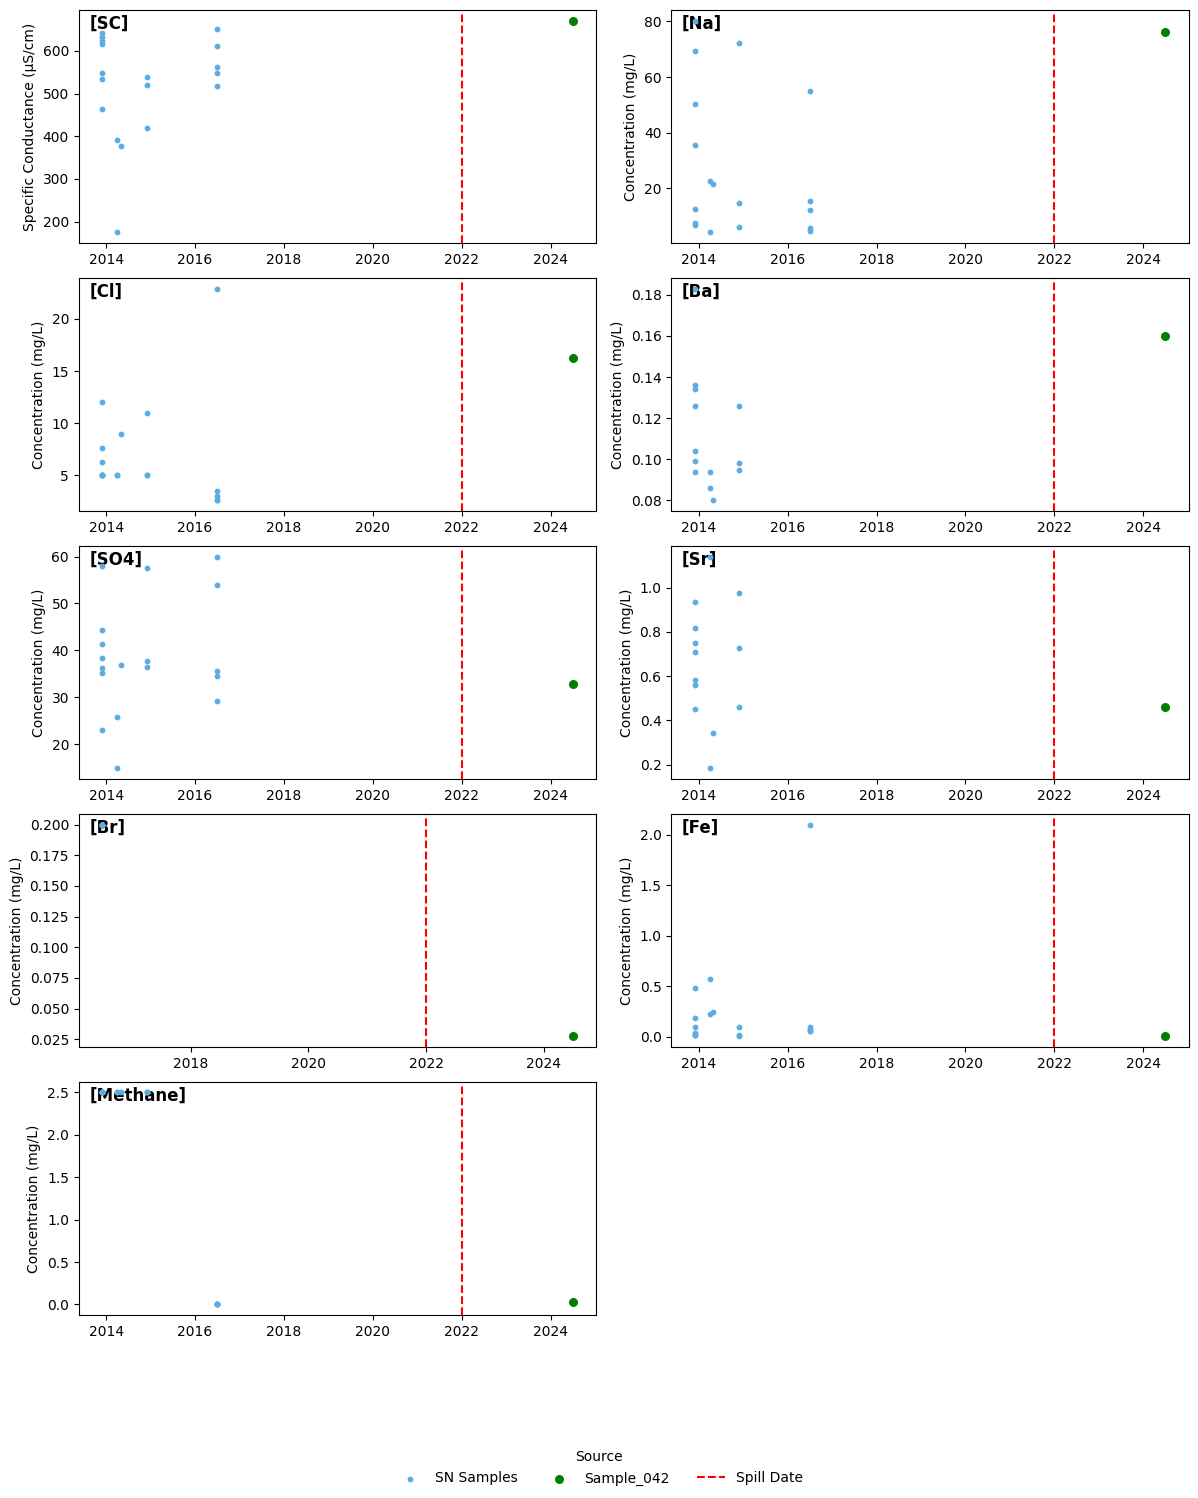

In [119]:
# scatter plot for sample 042
plot_scatter_time_series(nearby_samples_042, None, analyte, Sample_042, '2021-12-04')

## **Spill C - Sample 090, 038**

In [ ]:
df_spill_c = df_original[df_original['Site ID'].isin(['Sample_090', 'Sample_038'])]

### Sample 090

In [ ]:
coords_090 = df_final[df_final['Site ID'] == 'Sample_090'][['Latitude', 'Longitude']].values[0]
sample_090_coords = [(coords_090[0], coords_090[1])]  # Coordinates of sample 090
Sample_090 = df_original[df_original['Site ID'] == 'Sample_090']
# Find samples within 1km of sample 090
nearby_samples_090, closest_sample_090, min_dist_090 = find_nearby_samples(df_wa, sample_090_coords, 1)
# Display the nearby samples
nearby_samples_090

,SN sample,Latitude,Longitude,Alkalinity,As,Ba,Benzene,Br,Cd,Ca,...,K,Propane,Na,SC,Sr,SO4,Toluene,Xylene(total),Date,label
0,162,40.07889,-80.18494,290.0,0.01,0.358,NaN,NaN,NaN,97.996,...,1.626,NaN,6.363,582.0,0.600,19.0,NaN,NaN,2012-02-24,1
1,163,40.07944,-80.18089,52.0,0.01,0.153,NaN,NaN,NaN,37.967,...,1.209,NaN,29.318,190.0,0.411,23.0,NaN,NaN,2012-02-23,1
2,164,40.07919,-80.18169,159.0,0.01,0.080,NaN,NaN,NaN,17.960,...,0.757,NaN,7.181,367.0,0.097,13.0,NaN,NaN,2012-02-23,1
3,165,40.07486,-80.18319,138.0,0.01,0.114,NaN,NaN,NaN,48.691,...,0.598,NaN,3.197,333.0,0.202,17.0,NaN,NaN,2012-02-23,1
4,166,40.07433,-80.17800,214.0,0.01,0.047,NaN,NaN,NaN,69.917,...,0.830,NaN,3.272,450.0,0.161,19.0,NaN,NaN,2012-02-23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,4013,40.08802,-80.17929,224.0,0.01,0.077,NaN,NaN,NaN,77.800,...,1.430,NaN,6.960,469.6,0.480,25.8,NaN,NaN,2012-09-06,1
154,4014,40.08911,-80.17690,268.0,0.01,0.113,NaN,NaN,NaN,98.198,...,0.637,NaN,5.392,612.0,0.329,48.0,NaN,NaN,2012-08-16,1
155,4017,40.08263,-80.17949,221.0,0.01,0.548,NaN,NaN,NaN,26.900,...,3.100,NaN,229.000,1192.0,0.724,74.0,NaN,NaN,2012-08-23,1
156,4018,40.08907,-80.17802,251.0,0.01,0.209,NaN,NaN,NaN,87.384,...,1.317,NaN,9.647,612.0,0.404,29.0,NaN,NaN,2012-08-16,1


In [122]:
# Compare the closest sample with sample 090
Sample_090_comparison = compare_nearby_samples_with_sample(nearby_samples_090, closest_sample_090, min_dist_090, Sample_090)
Sample_090_comparison.to_csv(OUTPUT_DIR/'Tables/Table S15 Comparison result for Sample_090.csv', index=True)
Sample_090_comparison

C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,Sample_090,Closest Sample (2.89 m)(2012-10-18),Nearby Samples Min,Nearby Samples Median,Nearby Samples Max
SC,551.000,1885.7,166.100,708.750,6500.00
Na,47.300,462.0,0.500,50.800,1560.00
Cl,80.700,244.0,5.000,34.000,1950.00
Ba,0.070,0.413,0.005,0.203,5.14
SO4,47.800,5.0,5.000,20.750,188.00
Sr,0.250,0.319,0.010,0.388,6.51
Br,0.034,NaN,NaN,NaN,NaN
Fe,0.020,0.01,0.010,0.100,189.00
Methane,0.003,51.1,2.500,2.500,78.20


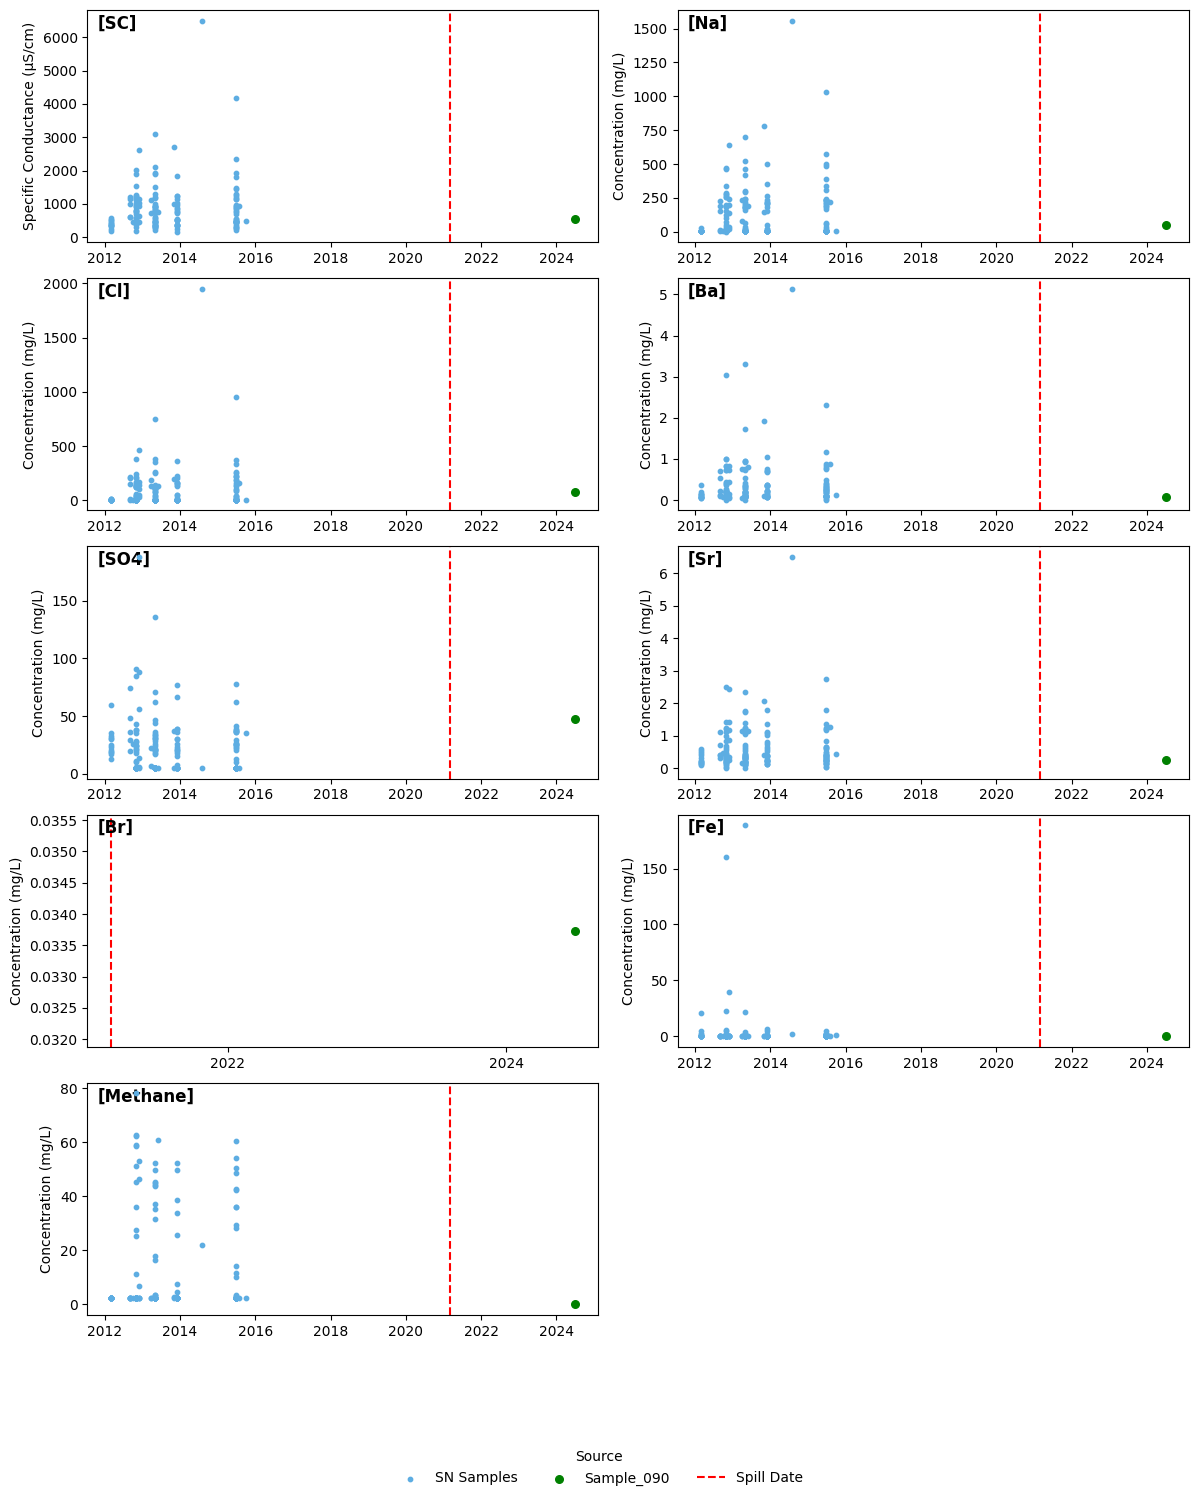

: 

In [ ]:
# Plot the time series data for sample 090
plot_scatter_time_series(nearby_samples_090, None, analyte, Sample_090, '2021-02-12')

### Sample_038

In [ ]:
coords_038 = df_final[df_final['Site ID'] == 'Sample_038'][['Latitude', 'Longitude']].values[0]
sample_038_coords = [(coords_038[0], coords_038[1])]  # Coordinates of sample 042
Sample_038 = df_original[df_original['Site ID'] == 'Sample_038']
# Find samples within 1km of sample 038
# nearby_samples_038, closest_sample_038, min_dist_038 = find_nearby_samples(df_wa, sample_038_coords, 1)
# Display the nearby samples
print("No nearby samples found for sample 038 within 1km radius.")

No nearby samples found for sample 038 within 1km radius.


## **Spill D - Sample 081, 084**

### Sample_081

In [ ]:
coords_081 = df_final[df_final['Site ID'] == 'Sample_081'][['Latitude', 'Longitude']].values[0]
sample_081_coords = [(coords_081[0], coords_081[1])]  # Coordinates of sample 081
# Find samples within 1km of sample 081
# nearby_samples_guyton_081, closest_sample_guyton_081, min_dist_guyton_081 = find_nearby_samples(df_wa, sample_081_coords, 1.0)
# Display the nearby samples
print("No nearby samples found for sample 081 within 1km radius.")

No nearby samples found for sample 081 within 1km radius.


### Sample_084

In [126]:
sample_084_coords = (40.20057901, -80.12164099)  # Coordinates of sample 084
Sample_084 = df_original[df_original['Site ID'] == 'Sample_084']
# Find samples within 1km of sample 084
# nearby_samples_range_084, closest_sample_range_084, min_dist_range_084 = find_nearby_samples(df_wa, [sample_084_coords], 1.0)
print("No nearby samples found for sample 084 within 1km radius.")
# nearby_samples_range_084


No nearby samples found for sample 084 within 1km radius.


## **Spill E - Sample_083**

In [ ]:
coords_083 = df_final[df_final['Site ID'] == 'Sample_083'][['Latitude', 'Longitude']].values[0]
sample_083_coords = [(coords_083[0], coords_083[1])]  # Coordinates of sample 083
Sample_083 = df_original[df_original['Site ID'] == 'Sample_083']
# Find samples within 1km of sample 083
nearby_samples_083, closest_sample_083, min_dist_083 = find_nearby_samples(df_wa, sample_083_coords, 1)
nearby_samples_083

,SN sample,Latitude,Longitude,Alkalinity,As,Ba,Benzene,Br,Cd,Ca,...,K,Propane,Na,SC,Sr,SO4,Toluene,Xylene(total),Date,label
0,1741,40.10774,-80.39955,212.0,0.01,0.066,1.0,NaN,0.005,68.7,...,1.100,1.42,3.73,407.1,0.211,32.6,1.0,1.0,2016-01-22,1
1,1744,40.11104,-80.40088,346.0,0.01,0.318,1.0,NaN,0.005,45.2,...,1.510,1.42,118.00,664.8,0.672,13.5,1.0,1.0,2016-01-21,1
2,1745,40.11113,-80.40087,193.0,0.01,0.110,1.0,0.10,0.005,94.0,...,1.220,1.42,53.40,766.3,0.304,34.6,1.0,1.0,2016-01-21,1
3,1759,40.10848,-80.40049,32.8,0.01,0.197,1.0,NaN,0.005,21.0,...,2.040,1.42,1.93,103.3,0.068,19.0,1.0,1.0,2016-01-27,1
4,1760,40.10716,-80.40224,207.0,0.01,0.067,1.0,NaN,0.005,80.6,...,1.420,1.42,3.93,466.0,0.221,37.5,1.0,1.0,2016-01-27,1
5,2682,40.10777,-80.39948,199.0,0.01,0.079,1.0,NaN,0.005,76.6,...,1.280,1.42,4.54,498.4,0.268,44.0,1.0,1.0,2015-06-18,1
6,2684,40.11124,-80.39991,146.0,0.01,0.068,1.0,NaN,0.005,69.4,...,2.070,1.42,49.30,741.5,0.407,92.5,1.0,1.0,2015-06-24,1
7,2685,40.11109,-80.40080,315.0,0.01,0.309,1.0,NaN,0.005,38.1,...,1.460,1.42,117.00,655.0,0.669,10.3,1.0,1.0,2015-06-22,1
8,2686,40.11111,-80.40084,162.0,0.01,0.120,1.0,2.68,0.005,91.0,...,1.600,1.42,58.00,833.8,0.324,30.7,1.0,1.0,2015-06-22,1
9,2701,40.10848,-80.40064,25.7,0.01,0.035,1.0,NaN,0.005,15.6,...,0.988,1.42,1.97,101.8,0.052,17.4,1.0,1.0,2015-07-01,1


In [128]:
Sample_083_comparison = compare_nearby_samples_with_sample(nearby_samples_083, closest_sample_083, min_dist_083, Sample_083)
Sample_083_comparison.to_csv(OUTPUT_DIR/'Tables/Table S16 Comparison result for Sample_083.csv', index=True)
Sample_083_comparison

,Sample_083,Closest Sample (677.7 m)(2016-01-27),Nearby Samples Min,Nearby Samples Median,Nearby Samples Max
SC,621.000,466.0,101.800,482.200,833.800
Na,33.100,3.93,1.850,4.235,118.000
Cl,23.800,10.0,5.000,14.500,149.000
Ba,0.090,0.067,0.035,0.084,0.318
SO4,110.000,37.5,10.300,28.100,92.500
Sr,0.270,0.221,0.052,0.244,0.672
Br,0.059,NaN,0.100,1.390,2.680
Fe,0.005,0.06,0.020,0.224,16.400
Methane,0.000,0.23,0.230,0.230,0.230


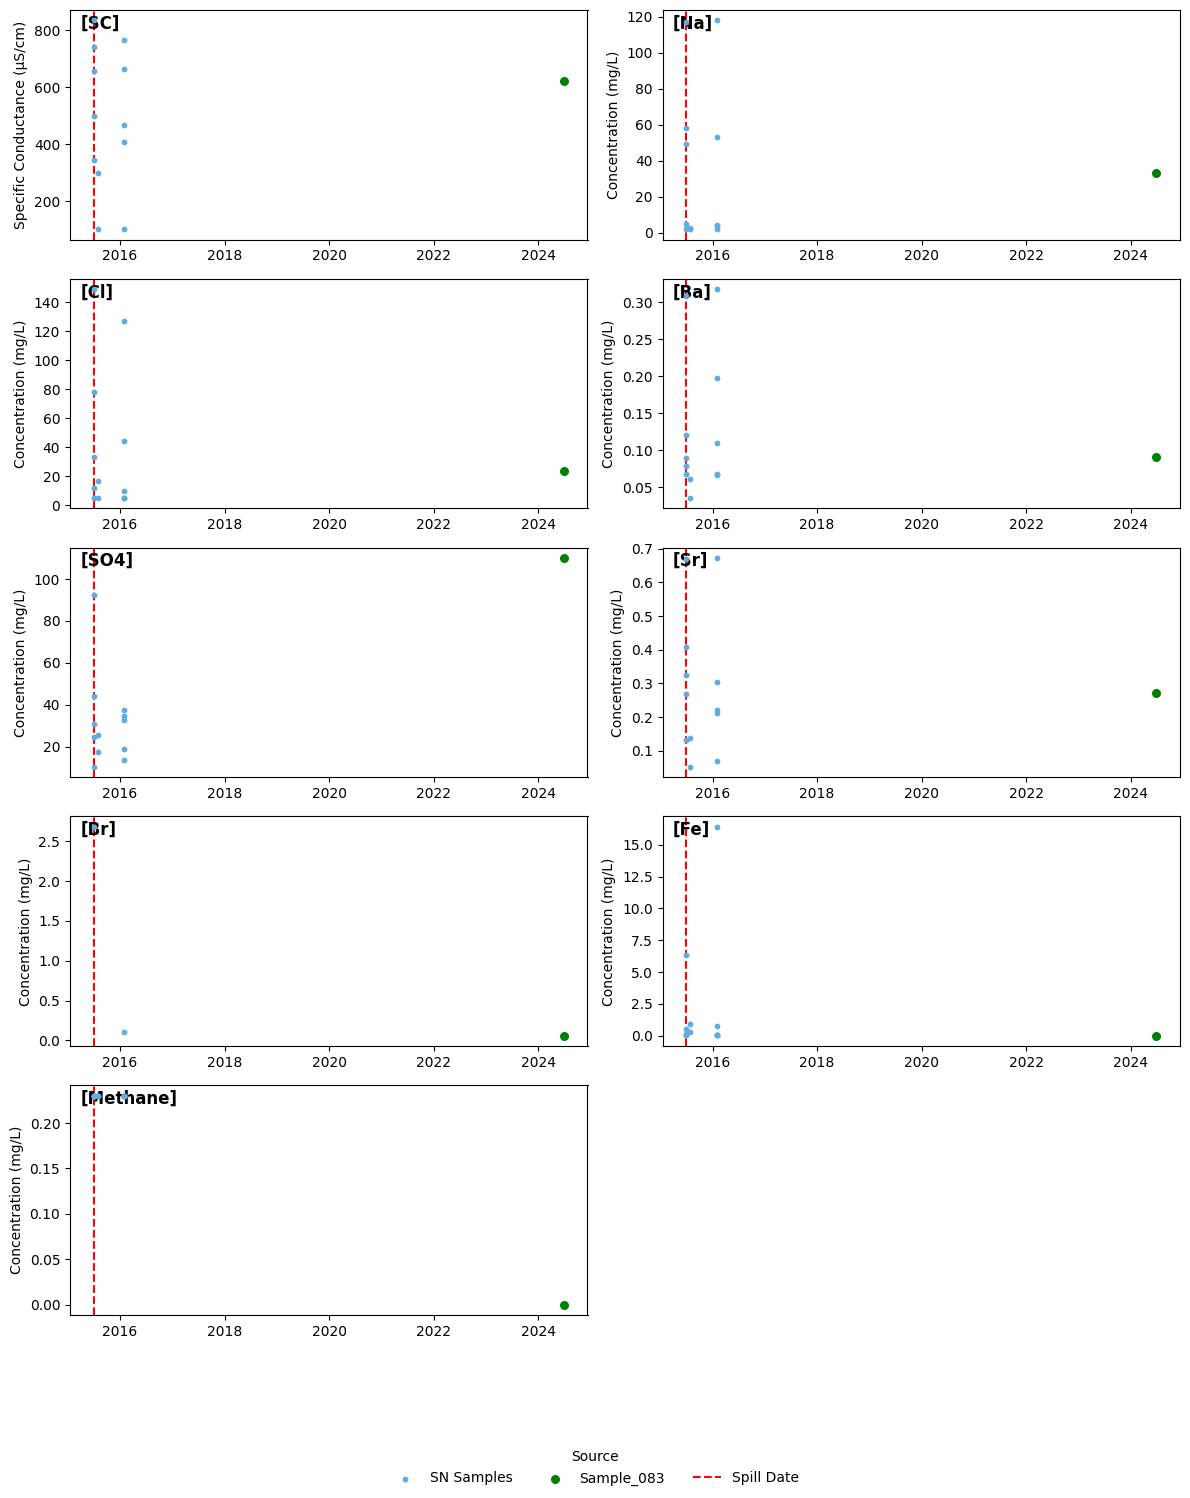

In [129]:
# Plot the time series data for sample 083
plot_scatter_time_series(nearby_samples_083, None, analyte, Sample_083, '2015-06-06')